# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [3]:
seed = randint(0, 4294967295)
print(seed)

60412887


In [4]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,slope_peak,major_vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


<Axes: >

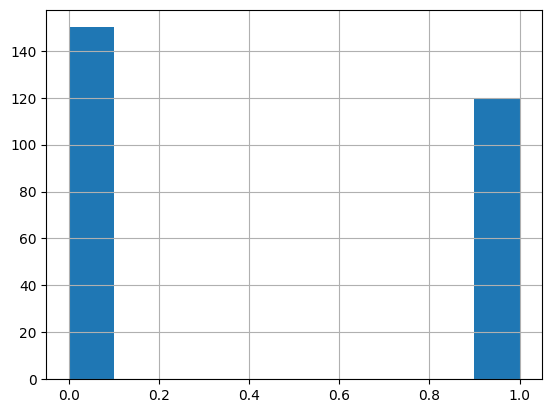

In [5]:
df['target'].hist()

<Axes: >

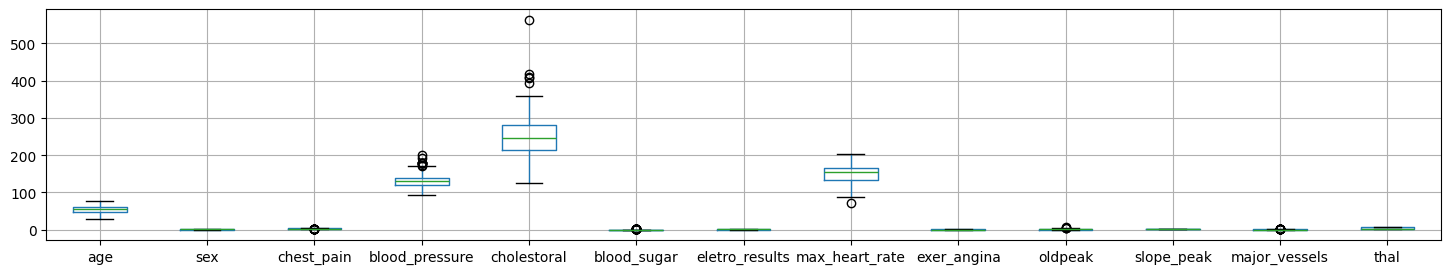

In [6]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

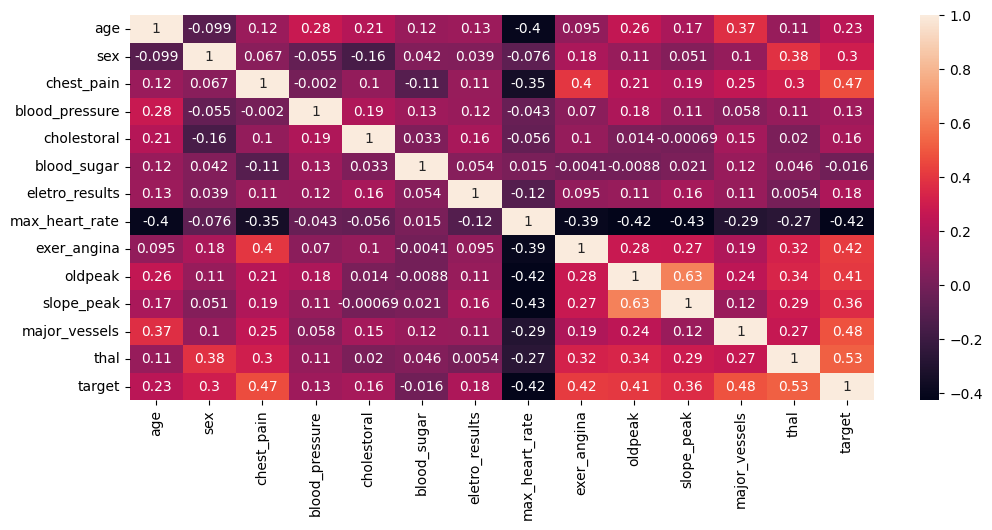

In [7]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [8]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [9]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)

In [87]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)

In [10]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)
Xa_test_norm = scaler.transform(Xa_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [88]:
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [11]:
NUM_TRIALS = 25
performs = {}
pred_hits = pd.DataFrame()
models = []

In [12]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}

### Decision Tree

In [13]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 60}


In [14]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.7979
Recall:           0.8250
Precision:        0.7333
F1:               0.7765
AUROC:            0.8014
AUPR:             0.6795
1-maxProb média:  0.2021
1-maxProb dp:     0.0618

[Testing]

Accuracy:         0.7474
Recall:           0.7045
Precision:        0.7381
F1:               0.7209
AUROC:            0.7444
AUPR:             0.6569
1-maxProb média:  0.1976
1-maxProb dp:     0.0615


In [15]:
pred_hits['dtree'] = dtree.predict(Xb_test) == yb_test
pred_hits.head()

,dtree
115,False
131,True
12,False
40,True
51,True


In [16]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [17]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l2'}


In [18]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
pred_hits['sgd'] = sgd.predict(Xb_test_norm) == yb_test
models.append(sgd)

[Training]

Accuracy:         0.8511
Recall:           0.8250
Precision:        0.8250
F1:               0.8250
AUROC:            0.8662
AUPR:             0.7826
1-maxProb média:  0.0067
1-maxProb dp:     0.0456

[Testing]

Accuracy:         0.8000
Recall:           0.6818
Precision:        0.8571
F1:               0.7595
AUROC:            0.7986
AUPR:             0.7490
1-maxProb média:  0.0031
1-maxProb dp:     0.0301


### Logistic Regression

In [19]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [20]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
pred_hits['lr'] = lr.predict(Xb_test_norm) == yb_test
models.append(lr)

[Training]

Accuracy:         0.8830
Recall:           0.8750
Precision:        0.8537
F1:               0.8642
AUROC:            0.9509
AUPR:             0.9388
1-maxProb média:  0.3741
1-maxProb dp:     0.0711

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9184
AUPR:             0.9085
1-maxProb média:  0.3609
1-maxProb dp:     0.0711


### K-Nearest Neighbors

(KNN)

In [21]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [22]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
pred_hits['knn'] = knn.predict(Xb_test_norm) == yb_test
models.append(knn)

[Training]

Accuracy:         0.9149
Recall:           0.8500
Precision:        0.9444
F1:               0.8947
AUROC:            0.9697
AUPR:             0.9538
1-maxProb média:  0.1213
1-maxProb dp:     0.1436

[Testing]

Accuracy:         0.8000
Recall:           0.6591
Precision:        0.8788
F1:               0.7532
AUROC:            0.8968
AUPR:             0.8617
1-maxProb média:  0.1411
1-maxProb dp:     0.1559


### Support Vector Machine - Linear
(SVM)

In [23]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [24]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
pred_hits['svm_linear'] = svm_linear.predict(Xb_test_norm) == yb_test
models.append(svm_linear)

[Training]

Accuracy:         0.9149
Recall:           0.8750
Precision:        0.9211
F1:               0.8974
AUROC:            0.9630
AUPR:             0.9444
1-maxProb média:  0.1702
1-maxProb dp:     0.1280

[Testing]

Accuracy:         0.8421
Recall:           0.7727
Precision:        0.8718
F1:               0.8193
AUROC:            0.9234
AUPR:             0.9108
1-maxProb média:  0.1469
1-maxProb dp:     0.1313


### Support Vector Machine - Polynomial
(SVM)

In [25]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [26]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
pred_hits['svm_poly'] = svm_poly.predict(Xb_test_norm) == yb_test
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9000
Precision:        1.0000
F1:               0.9474
AUROC:            0.9986
AUPR:             0.9981
1-maxProb média:  0.0932
1-maxProb dp:     0.1111

[Testing]

Accuracy:         0.8526
Recall:           0.7500
Precision:        0.9167
F1:               0.8250
AUROC:            0.8801
AUPR:             0.8544
1-maxProb média:  0.1042
1-maxProb dp:     0.1226


### Support Vector Machine - RBF
(SVM)

In [27]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [28]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
pred_hits['svm_rbf'] = svm_rbf.predict(Xb_test_norm) == yb_test
models.append(svm_rbf)

[Training]

Accuracy:         0.9468
Recall:           0.9000
Precision:        0.9730
F1:               0.9351
AUROC:            0.9931
AUPR:             0.9905
1-maxProb média:  0.0934
1-maxProb dp:     0.0960

[Testing]

Accuracy:         0.8105
Recall:           0.6364
Precision:        0.9333
F1:               0.7568
AUROC:            0.9135
AUPR:             0.8953
1-maxProb média:  0.1644
1-maxProb dp:     0.1574


### Multi-Layer Perceptron
(MLP)

In [29]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}


In [30]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
pred_hits['mlp'] = mlp.predict(Xb_test_norm) == yb_test
models.append(mlp)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0175
1-maxProb dp:     0.0313

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8859
AUPR:             0.8760
1-maxProb média:  0.0349
1-maxProb dp:     0.0774


### Kolmogorov-Arnold Network
(KAN)

In [31]:
kanet = KANClassifier([13,2,2,2], grid=5, lr=0.005, lamb=0.01, grid_eps=1, random_state=seed, steps=10)

cross_val_score(kanet, X=Xb_train_norm, y=yb_train, cv=5, error_score=0)

kanet = kanet.fit(Xb_train_norm, yb_train)

| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 1.17e+00 | : 100%|█| 10/10 [00:02<00:00,  3.60it
| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 1.21e+00 | : 100%|█| 10/10 [00:02<00:00,  4.64it
| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 1.13e+00 | : 100%|█| 10/10 [00:02<00:00,  4.74it
| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 1.01e+00 | : 100%|█| 10/10 [00:02<00:00,  4.57it
| train_loss: 8.25e-01 | test_loss: 8.25e-01 | reg: 1.51e+00 | : 100%|█| 10/10 [00:02<00:00,  4.68it
| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 1.31e+00 | : 100%|█| 10/10 [00:02<00:00,  4.58it


In [45]:
len(Xb_test)*4/5

76.0

In [33]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

best_score = 0
for w in kan_params['width']:
    for g in kan_params['grid']:
        for lr in kan_params['lr']:
            for l in kan_params['lamb']:
                score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                if(score > best_score):
                    best_score = score
                    best_width = w
                    best_grid = g
                    best_lr = lr
                    best_lamb = l

kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed).fit(Xb_train_norm, yb_train)

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 1.97e+00 | : 100%|█| 15/15 [00:03<00:00,  4.60it
| train_loss: 1.75e-01 | test_loss: 1.75e-01 | reg: 2.60e+01 | : 100%|█| 15/15 [00:03<00:00,  4.62it
| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 2.48e+01 | : 100%|█| 15/15 [00:03<00:00,  4.65it
| train_loss: 8.26e-01 | test_loss: 8.26e-01 | reg: 2.34e+00 | : 100%|█| 15/15 [00:03<00:00,  4.71it
| train_loss: 8.25e-01 | test_loss: 8.25e-01 | reg: 2.41e+00 | : 100%|█| 15/15 [00:03<00:00,  4.51it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 1.92e+00 | : 100%|█| 15/15 [00:03<00:00,  4.58it
| train_loss: 8.27e-01 | test_loss: 8.27e-01 | reg: 1.58e+00 | : 100%|█| 15/15 [00:02<00:00,  6.00it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 1.29e+00 | : 100%|█| 15/15 [00:02<00:00,  5.88it
| train_loss: 8.28e-01 | test_loss: 8.28e-01 | reg: 1.71e+00 | : 100%|█| 15/15 [00:03<00:00,  4.98it
| train_loss: 8.28e-01 | test_loss: 8.28e-01 | reg: 1.73e+00 | : 100%|█| 15/15 [00:03<00:00

width: [[13, 0], [3, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [34]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
pred_hits['kan'] = kanet.predict(Xb_test_norm) == yb_test
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0095
1-maxProb dp:     0.0210

[Testing]

Accuracy:         0.8421
Recall:           0.7727
Precision:        0.8718
F1:               0.8193
AUROC:            0.8859
AUPR:             0.8470
1-maxProb média:  0.0355
1-maxProb dp:     0.0797


### Random Forest

In [35]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [36]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
pred_hits['rforest'] = rforest.predict(Xb_test) == yb_test
models.append(rforest)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.1112
1-maxProb dp:     0.0923

[Testing]

Accuracy:         0.8316
Recall:           0.7273
Precision:        0.8889
F1:               0.8000
AUROC:            0.9191
AUPR:             0.8999
1-maxProb média:  0.2053
1-maxProb dp:     0.1423


### Gradient Boosting

In [37]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 150}


In [38]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
pred_hits['gb'] = gb.predict(Xb_test) == yb_test
models.append(gb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0084
1-maxProb dp:     0.0092

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8984
AUPR:             0.8790
1-maxProb média:  0.0522
1-maxProb dp:     0.0982


### AdaBoost

In [39]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.1, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [40]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
pred_hits['adab'] = adab.predict(Xb_test) == yb_test
models.append(adab)

[Training]

Accuracy:         0.9574
Recall:           0.9500
Precision:        0.9500
F1:               0.9500
AUROC:            0.9981
AUPR:             0.9976
1-maxProb média:  0.4255
1-maxProb dp:     0.0508

[Testing]

Accuracy:         0.8105
Recall:           0.6818
Precision:        0.8824
F1:               0.7692
AUROC:            0.8857
AUPR:             0.8305
1-maxProb média:  0.4237
1-maxProb dp:     0.0490


### XGBoost

In [41]:
xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
         

In [42]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
pred_hits['xgb'] = xgb.predict(Xb_test) == yb_test
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0784
1-maxProb dp:     0.0837

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9033
AUPR:             0.8933
1-maxProb média:  0.0948
1-maxProb dp:     0.1139


## Análise de Correlações

In [43]:
pred_corrls = pd.DataFrame(columns=pred_hits.columns, index=pred_hits.columns, dtype=float)
size_preds = len(pred_hits)

for m in pred_hits.columns:
    for n in pred_hits.columns:
        pred_corrls.at[m,n] = ((pred_hits[m] == pred_hits[n]).sum())/size_preds

pred_corrls

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.842105,0.905263,0.821053,0.884211,0.873684,0.810526,0.831579,0.842105,0.873684,0.873684,0.810526,0.884211
sgd,0.842105,1.000000,0.894737,0.894737,0.915789,0.926316,0.926316,0.905263,0.873684,0.884211,0.863158,0.863158,0.873684
lr,0.905263,0.894737,1.000000,0.894737,0.978947,0.947368,0.863158,0.884211,0.894737,0.947368,0.905263,0.905263,0.915789
knn,0.821053,0.894737,0.894737,1.000000,0.894737,0.926316,0.884211,0.863158,0.852632,0.926316,0.905263,0.884211,0.894737
svm_linear,0.884211,0.915789,0.978947,0.894737,1.000000,0.947368,0.884211,0.905263,0.873684,0.947368,0.905263,0.905263,0.915789
svm_poly,0.873684,0.926316,0.947368,0.926316,0.947368,1.000000,0.915789,0.894737,0.884211,0.936842,0.915789,0.894737,0.926316
svm_rbf,0.810526,0.926316,0.863158,0.884211,0.884211,0.915789,1.000000,0.873684,0.884211,0.873684,0.852632,0.873684,0.863158
mlp,0.831579,0.905263,0.884211,0.863158,0.905263,0.894737,0.873684,1.000000,0.884211,0.852632,0.852632,0.894737,0.842105
kan,0.842105,0.873684,0.894737,0.852632,0.873684,0.884211,0.884211,0.884211,1.000000,0.863158,0.863158,0.863158,0.873684
rforest,0.873684,0.884211,0.947368,0.926316,0.947368,0.936842,0.873684,0.852632,0.863158,1.000000,0.957895,0.915789,0.968421


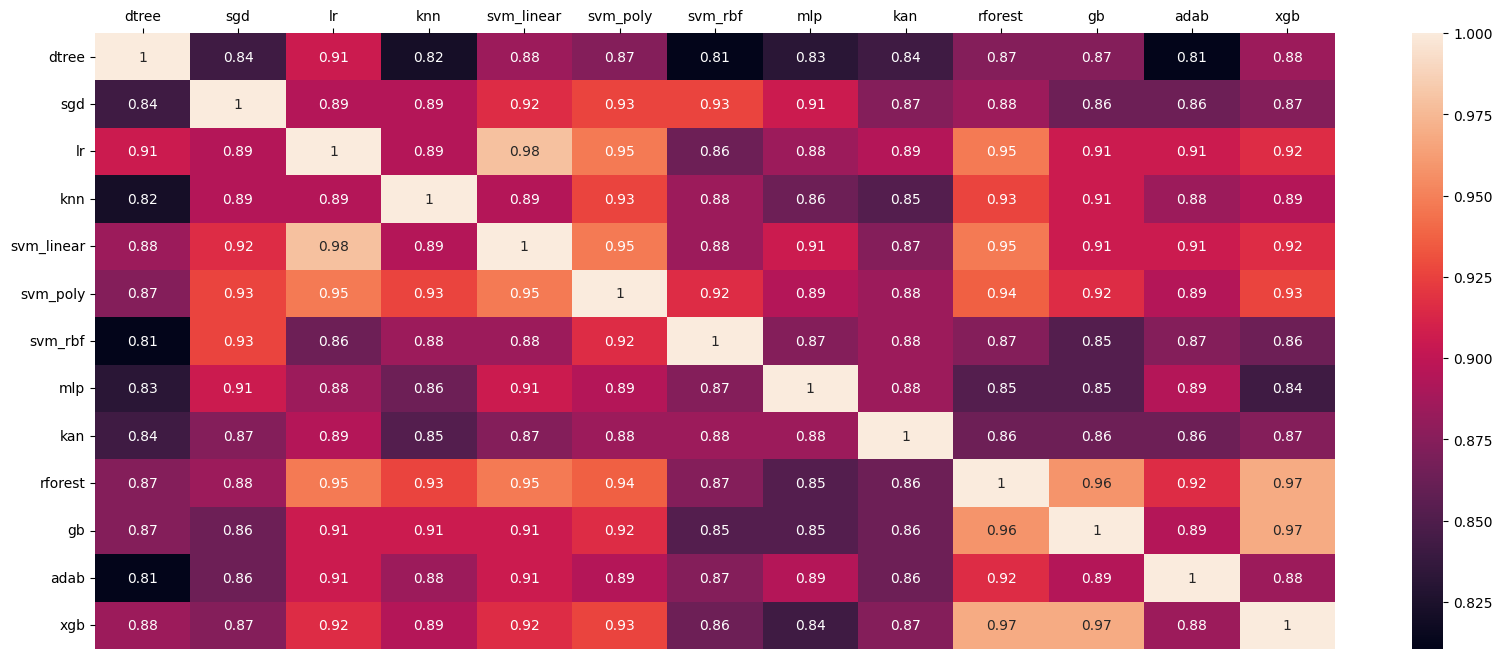

In [44]:
plt.figure(figsize=(20,8))
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()

In [46]:
corrls_values = pd.Series(pred_corrls.values.reshape((169,)))
corrls_values.describe()

count    169.000000
mean       0.899346
std        0.044479
min        0.810526
25%        0.873684
50%        0.894737
75%        0.915789
max        1.000000
dtype: float64

<Axes: >

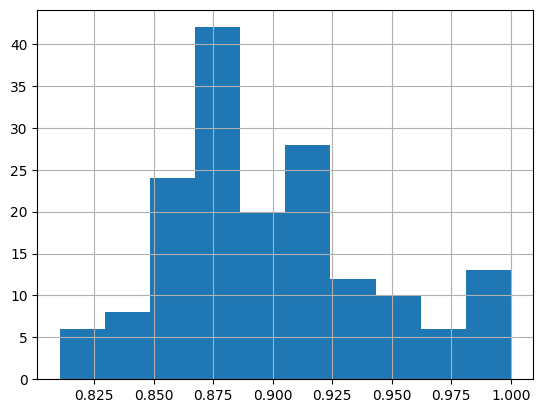

In [47]:
corrls_values.hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [ ]:
def group_search_help(df:pd.DataFrame, min_score:int, models:list|set=None, base_group:list=[]):
    if(models is None):
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']
    
    if(len(base_group)==0):
        base_group, models = models[:1], models[1:]
    
    output_groups = []

    for m in models:
        i = 0
        check = True
        while(check and i<len(base_group)):
            corr = df.at[base_group[i],m]
            if(np.isnan(corr)):
                check = False
            elif(corr < min_score):
                check = False
            i+=1
        if(check):
            temp = models.copy()
            temp.remove(m)
            output_groups.append(group_search_help(df, min_score, temp, base_group+[m]))

    if(len(output_groups)==0):
        return base_group

    return output_groups

def group_search(df:pd.DataFrame, min_score:int, models:list=None):
    if(models is None):
        models_dict = {'dtree':0, 'sgd':0, 'lr':0, 'knn':0, 'svm_linear':0, 'svm_poly':0, 'svm_rbf':0, 'mlp':0,
                  'kan':0, 'rforest':0, 'gb':0, 'adab':0, 'xgb':0}
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']
    
    df.map(lambda x: np.NAN if x<min_score else x)

    groups = []
    for i in range(len(models)):
        groups.append(group_search_help(df, min_score, models[i:]))
        #if(type(new_group[0])==list):
        #groups += new_group
        #for n in groups[-1]:
        #    if(n in models):
        #        models.remove(n)
    return groups


# isso tá mto porco mds q vergonha

groups_list = []

def unsqueeze(lista):
    global groups_list
    if(type(lista[0])!=list):
        groups_list.append(lista)
    else:
        if(len(lista)==1):
            unsqueeze(lista[0])
        else:
            for i in range(len(lista)):
                unsqueeze(lista[i])


def clean_list(lista):
    global group_list
    groups_list = []

    unsqueeze(lista)

    for i in range(len(groups_list)):
        groups_list[i] = set(groups_list[i])
    
    i = 0
    while i < len(groups_list):
        while j < len(groups_list):
        if(groups_list.count(groups_list[i])>1):
            groups_list.pop(i)
        else:
            i+=1

In [282]:
set([1,2]) <= set([2,1])

True

In [49]:
min_score = corrls_values.quantile(0.75)

pred_corrls_min = pred_corrls.map(lambda x: np.NAN if (x<min_score) or (x==1) else x)

print('Min_score:', min_score)

pred_corrls_min

Min_score: 0.9157894736842105


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sgd,NaN,NaN,NaN,NaN,0.915789,0.926316,0.926316,NaN,NaN,NaN,NaN,NaN,NaN
lr,NaN,NaN,NaN,NaN,0.978947,0.947368,NaN,NaN,NaN,0.947368,NaN,NaN,0.915789
knn,NaN,NaN,NaN,NaN,NaN,0.926316,NaN,NaN,NaN,0.926316,NaN,NaN,NaN
svm_linear,NaN,0.915789,0.978947,NaN,NaN,0.947368,NaN,NaN,NaN,0.947368,NaN,NaN,0.915789
svm_poly,NaN,0.926316,0.947368,0.926316,0.947368,NaN,0.915789,NaN,NaN,0.936842,0.915789,NaN,0.926316
svm_rbf,NaN,0.926316,NaN,NaN,NaN,0.915789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mlp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rforest,NaN,NaN,0.947368,0.926316,0.947368,0.936842,NaN,NaN,NaN,NaN,0.957895,0.915789,0.968421


In [63]:
unsqueeze(group_search(pred_corrls_min, min_score))

for i in range(len(groups_list)):
    groups_list[i].sort()

i = 0
while i < len(groups_list):
    if(groups_list.count(groups_list[i])>1):
        groups_list.pop(i)
    else:
        i+=1

for g in groups_list:
    if(len(g)>1):
        print(g)

['sgd', 'svm_linear', 'svm_poly']
['sgd', 'svm_poly', 'svm_rbf']
['lr', 'rforest', 'svm_linear', 'svm_poly', 'xgb']
['knn', 'rforest', 'svm_poly']
['rforest', 'svm_linear', 'svm_poly', 'xgb']
['svm_poly', 'svm_rbf']
['gb', 'rforest', 'svm_poly', 'xgb']
['adab', 'rforest']
['gb', 'rforest', 'xgb']
['gb', 'xgb']


In [119]:
true_groups = groups_list.copy()

In [118]:
groups_list

[['dtree'],
 ['sgd', 'svm_linear', 'svm_poly'],
 ['sgd', 'svm_poly', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear', 'svm_poly', 'xgb'],
 ['knn', 'rforest', 'svm_poly'],
 ['rforest', 'svm_linear', 'svm_poly', 'xgb'],
 ['svm_poly', 'svm_rbf'],
 ['gb', 'rforest', 'svm_poly', 'xgb'],
 ['svm_rbf'],
 ['mlp'],
 ['kan'],
 ['adab', 'rforest'],
 ['gb', 'rforest', 'xgb'],
 ['gb', 'xgb'],
 ['adab'],
 ['xgb']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

## Globais

In [64]:
df_assessor = pd.concat([Xb_test, yb_test], axis=1)

#y_pred = dtree.predict(Xa_test)

model_names = list(performs.keys())

df_assessor[model_names] = np.NaN

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)
    df_assessor.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

df_assessor

,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,...,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
115,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,...,1.0,0.922145,0.962813,0.973425,0.999623,0.994169,0.85,0.999621,0.665205,0.962335
131,61.0,1.0,3.0,150.0,243.0,1.0,0.0,137.0,1.0,1.0,...,0.4,0.227860,0.138998,0.232454,0.047386,0.763134,0.30,0.033610,0.459122,0.513467
12,58.0,0.0,2.0,136.0,319.0,1.0,2.0,152.0,0.0,0.0,...,1.0,0.893359,0.972718,0.928617,0.999808,0.998929,0.75,0.998479,0.572783,0.909080
40,60.0,1.0,4.0,145.0,282.0,0.0,2.0,142.0,1.0,2.8,...,0.0,0.027827,0.012555,0.008787,0.000004,0.003914,0.00,0.000378,0.358806,0.017478
51,54.0,1.0,4.0,110.0,239.0,0.0,0.0,126.0,1.0,2.8,...,0.0,0.093144,0.034455,0.035390,0.004420,0.000991,0.10,0.000414,0.395542,0.020938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,41.0,1.0,2.0,135.0,203.0,0.0,0.0,132.0,0.0,0.0,...,0.2,0.254646,0.316882,0.297662,0.599503,0.002608,0.35,0.198490,0.468653,0.196135
66,51.0,1.0,4.0,140.0,299.0,0.0,0.0,173.0,1.0,1.6,...,0.6,0.373980,0.267533,0.500000,0.006898,0.001387,0.45,0.034072,0.453278,0.167693
137,54.0,1.0,3.0,120.0,258.0,0.0,2.0,147.0,0.0,0.4,...,0.4,0.525712,0.426520,0.525849,0.921146,0.988334,0.30,0.200049,0.489528,0.344218
50,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,...,0.0,0.025760,0.000017,0.352756,0.000035,0.000417,0.25,0.002058,0.421217,0.011064


### Regressor Chain
(RC)

In [65]:
Xa_train = df_assessor.loc[:,['age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'eletro_results', 'max_heart_rate', 'exer_angina',
       'oldpeak', 'slope_peak', 'major_vessels', 'thal', 'target']]

ya_train = df_assessor.loc[:,model_names]

In [66]:
ya_train

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
115,0.733333,1.0,0.682079,1.0,0.922145,0.962813,0.973425,0.999623,0.994169,0.85,0.999621,0.665205,0.962335
131,0.142857,0.0,0.447787,0.4,0.227860,0.138998,0.232454,0.047386,0.763134,0.30,0.033610,0.459122,0.513467
12,0.857143,1.0,0.657508,1.0,0.893359,0.972718,0.928617,0.999808,0.998929,0.75,0.998479,0.572783,0.909080
40,0.266667,0.0,0.250467,0.0,0.027827,0.012555,0.008787,0.000004,0.003914,0.00,0.000378,0.358806,0.017478
51,0.266667,0.0,0.315945,0.0,0.093144,0.034455,0.035390,0.004420,0.000991,0.10,0.000414,0.395542,0.020938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.733333,0.0,0.424479,0.2,0.254646,0.316882,0.297662,0.599503,0.002608,0.35,0.198490,0.468653,0.196135
66,0.266667,1.0,0.438634,0.6,0.373980,0.267533,0.500000,0.006898,0.001387,0.45,0.034072,0.453278,0.167693
137,0.733333,1.0,0.518547,0.4,0.525712,0.426520,0.525849,0.921146,0.988334,0.30,0.200049,0.489528,0.344218
50,0.266667,0.0,0.317631,0.0,0.025760,0.000017,0.352756,0.000035,0.000417,0.25,0.002058,0.421217,0.011064


In [67]:
Xa_train

,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,slope_peak,major_vessels,thal,target
115,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
131,61.0,1.0,3.0,150.0,243.0,1.0,0.0,137.0,1.0,1.0,2.0,0.0,3.0,0
12,58.0,0.0,2.0,136.0,319.0,1.0,2.0,152.0,0.0,0.0,1.0,2.0,3.0,1
40,60.0,1.0,4.0,145.0,282.0,0.0,2.0,142.0,1.0,2.8,2.0,2.0,7.0,1
51,54.0,1.0,4.0,110.0,239.0,0.0,0.0,126.0,1.0,2.8,2.0,1.0,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,41.0,1.0,2.0,135.0,203.0,0.0,0.0,132.0,0.0,0.0,2.0,0.0,6.0,0
66,51.0,1.0,4.0,140.0,299.0,0.0,0.0,173.0,1.0,1.6,1.0,0.0,7.0,1
137,54.0,1.0,3.0,120.0,258.0,0.0,2.0,147.0,0.0,0.4,2.0,0.0,7.0,0
50,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,2.0,3.0,7.0,1


In [68]:
regchain = RegressorChain(RandomForestRegressor(), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.2s
[Chain] ................ (12 of 13) Processing order 11, total=   0.2s
[Chain] ................ (13 of 13) Processing order 12, total=   0.2s


In [ ]:
ya_test = pd.DataFrame(ya_test)


for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

Xa_test.loc[:, 'target'] = ya_test['target']
ya_test = ya_test.drop(columns=['target'])

In [230]:
def mse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (y_true[c]**2 - y_pred[c]**2).mean()
    return error

def rmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = ((y_true[c]**2 - y_pred[c]**2)**0.5).mean()
    return error

def mae_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (abs(y_true[c] - y_pred[c])).mean()
    return error

In [231]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [204]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

MSE: 0.0680
RMSE: 0.2411
MAE: 0.1692


In [232]:
ya_pred = regchain.predict(Xa_test)

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.033744,0.062394,0.009225,0.057829,0.034379,0.053125,0.045077,0.089472,0.111956,0.053151,0.069094,0.007165,0.055314
multi-output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
pd.concat([Xa_test, ya_test], axis=1).head()

,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,...,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
0,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,...,0.6,0.791612,0.970153,0.759217,0.930490,0.992239,0.55,0.636015,0.539770,0.917054
1,51.0,0.0,4.0,130.0,305.0,0.0,0.0,142.0,1.0,1.2,...,0.2,0.534103,0.177594,0.182750,0.373908,0.940184,0.25,0.324749,0.505585,0.599195
2,48.0,1.0,4.0,124.0,274.0,0.0,2.0,166.0,0.0,0.5,...,0.4,0.433177,0.547447,0.461346,0.064477,0.002042,0.60,0.561520,0.512386,0.478614
3,66.0,1.0,2.0,160.0,246.0,0.0,0.0,120.0,1.0,0.0,...,0.2,0.098290,0.048227,0.298621,0.004582,0.042992,0.50,0.159529,0.472193,0.402046
4,56.0,1.0,4.0,125.0,249.0,1.0,2.0,144.0,1.0,1.2,...,0.2,0.500000,0.514898,0.571390,0.731841,0.005636,0.40,0.747523,0.522342,0.484199


Análise de correlações:

In [258]:
pred_hits2 = {}

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict(Xa_test.drop(columns=['target']))
    else:
        y_pred = models[i].predict(Xa_test_norm)
        
    pred_hits2[model_names[i]] = y_pred == Xa_test['target']

In [259]:
pred_corrls2 = pd.DataFrame(columns=model_names, index=model_names, dtype=float)
size_preds = len(ya_test)

for m in model_names:
    for n in model_names:
        pred_corrls2.at[m,n] = ((pred_hits2[m] == pred_hits2[n]).sum())/size_preds

pred_corrls2

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.753086,0.777778,0.753086,0.802469,0.753086,0.765432,0.753086,0.765432,0.765432,0.753086,0.753086,0.827160
sgd,0.753086,1.000000,0.901235,0.901235,0.925926,0.876543,0.888889,0.876543,0.814815,0.839506,0.827160,0.851852,0.901235
lr,0.777778,0.901235,1.000000,0.950617,0.925926,0.925926,0.888889,0.901235,0.814815,0.888889,0.876543,0.876543,0.901235
knn,0.753086,0.901235,0.950617,1.000000,0.876543,0.925926,0.913580,0.876543,0.790123,0.864198,0.876543,0.876543,0.876543
svm_linear,0.802469,0.925926,0.925926,0.876543,1.000000,0.901235,0.888889,0.901235,0.839506,0.888889,0.876543,0.901235,0.925926
svm_poly,0.753086,0.876543,0.925926,0.925926,0.901235,1.000000,0.888889,0.901235,0.765432,0.888889,0.925926,0.901235,0.851852
svm_rbf,0.765432,0.888889,0.888889,0.913580,0.888889,0.888889,1.000000,0.888889,0.777778,0.876543,0.888889,0.864198,0.864198
mlp,0.753086,0.876543,0.901235,0.876543,0.901235,0.901235,0.888889,1.000000,0.790123,0.864198,0.876543,0.876543,0.851852
kan,0.765432,0.814815,0.814815,0.790123,0.839506,0.765432,0.777778,0.790123,1.000000,0.802469,0.790123,0.814815,0.864198
rforest,0.765432,0.839506,0.888889,0.864198,0.888889,0.888889,0.876543,0.864198,0.802469,1.000000,0.913580,0.888889,0.888889


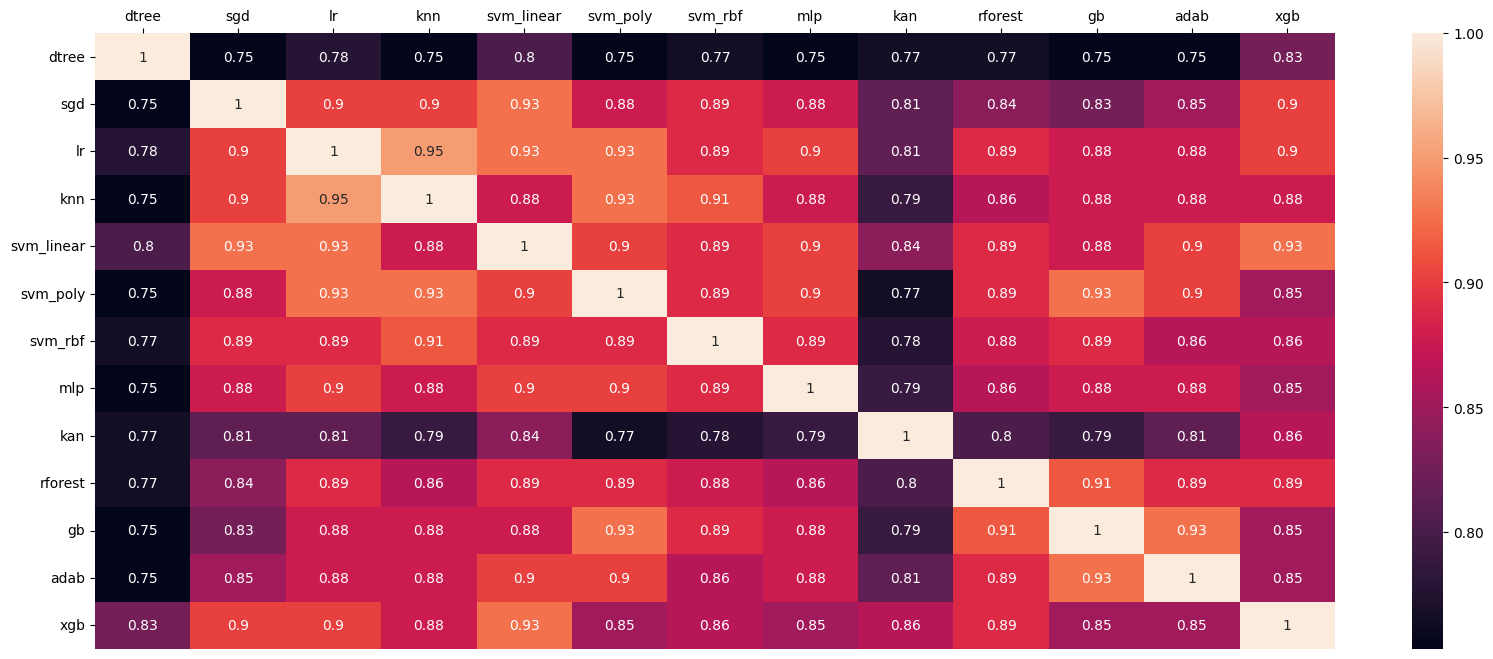

In [260]:
plt.figure(figsize=(20,8))
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()

In [262]:
corrls_values2 = pd.Series(pred_corrls2.values.reshape((169,)))
corrls_values2.describe()

count    169.000000
mean       0.868800
std        0.063962
min        0.753086
25%        0.827160
50%        0.876543
75%        0.901235
max        1.000000
dtype: float64

In [265]:
min_score = corrls_values2.quantile(0.75)

corrls_min = pred_corrls2.map(lambda x: np.NAN if (x<min_score) or (x==1) else x)

groups_list = []

unsqueeze(group_search(corrls_min, min_score))

for i in range(len(groups_list)):
    groups_list[i].sort()

i = 0
while i < len(groups_list):
    if(groups_list.count(groups_list[i])>1):
        groups_list.pop(i)
    else:
        i+=1

for g in groups_list:
    if(len(g)>1):
        print(g)

['knn', 'lr', 'sgd']
['lr', 'sgd', 'svm_linear', 'xgb']
['knn', 'lr', 'svm_poly']
['lr', 'mlp', 'svm_linear', 'svm_poly']
['lr', 'svm_linear', 'xgb']
['knn', 'svm_poly']
['knn', 'svm_rbf']
['mlp', 'svm_linear', 'svm_poly']
['adab', 'svm_linear', 'svm_poly']
['svm_linear', 'xgb']
['mlp', 'svm_poly']
['adab', 'gb', 'svm_poly']
['gb', 'rforest']
['adab', 'gb']


In [266]:
true_groups_a_data = groups_list.copy()

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

In [276]:
y_pred = pd.DataFrame(regchain.predict(Xa_test), columns=model_names)
y_pred = y_pred.map(round)

In [277]:
regchain_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    for n in model_names:
        regchain_corrls.at[m,n] = ((y_pred[m]==y_pred[n])).sum()/size_preds

regchain_corrls

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.938272,0.901235,0.901235,0.925926,0.962963,0.962963,0.901235,0.913580,0.950617,0.962963,0.888889,0.975309
sgd,0.938272,1.000000,0.962963,0.938272,0.987654,0.975309,0.975309,0.962963,0.925926,0.962963,0.975309,0.925926,0.938272
lr,0.901235,0.962963,1.000000,0.901235,0.975309,0.938272,0.938272,0.950617,0.913580,0.925926,0.938272,0.913580,0.901235
knn,0.901235,0.938272,0.901235,1.000000,0.925926,0.938272,0.938272,0.901235,0.888889,0.950617,0.938272,0.913580,0.901235
svm_linear,0.925926,0.987654,0.975309,0.925926,1.000000,0.962963,0.962963,0.975309,0.938272,0.950617,0.962963,0.913580,0.925926
svm_poly,0.962963,0.975309,0.938272,0.938272,0.962963,1.000000,1.000000,0.938272,0.925926,0.962963,0.975309,0.925926,0.962963
svm_rbf,0.962963,0.975309,0.938272,0.938272,0.962963,1.000000,1.000000,0.938272,0.925926,0.962963,0.975309,0.925926,0.962963
mlp,0.901235,0.962963,0.950617,0.901235,0.975309,0.938272,0.938272,1.000000,0.938272,0.925926,0.938272,0.888889,0.901235
kan,0.913580,0.925926,0.913580,0.888889,0.938272,0.925926,0.925926,0.938272,1.000000,0.913580,0.925926,0.901235,0.913580
rforest,0.950617,0.962963,0.925926,0.950617,0.950617,0.962963,0.962963,0.925926,0.913580,1.000000,0.987654,0.913580,0.950617


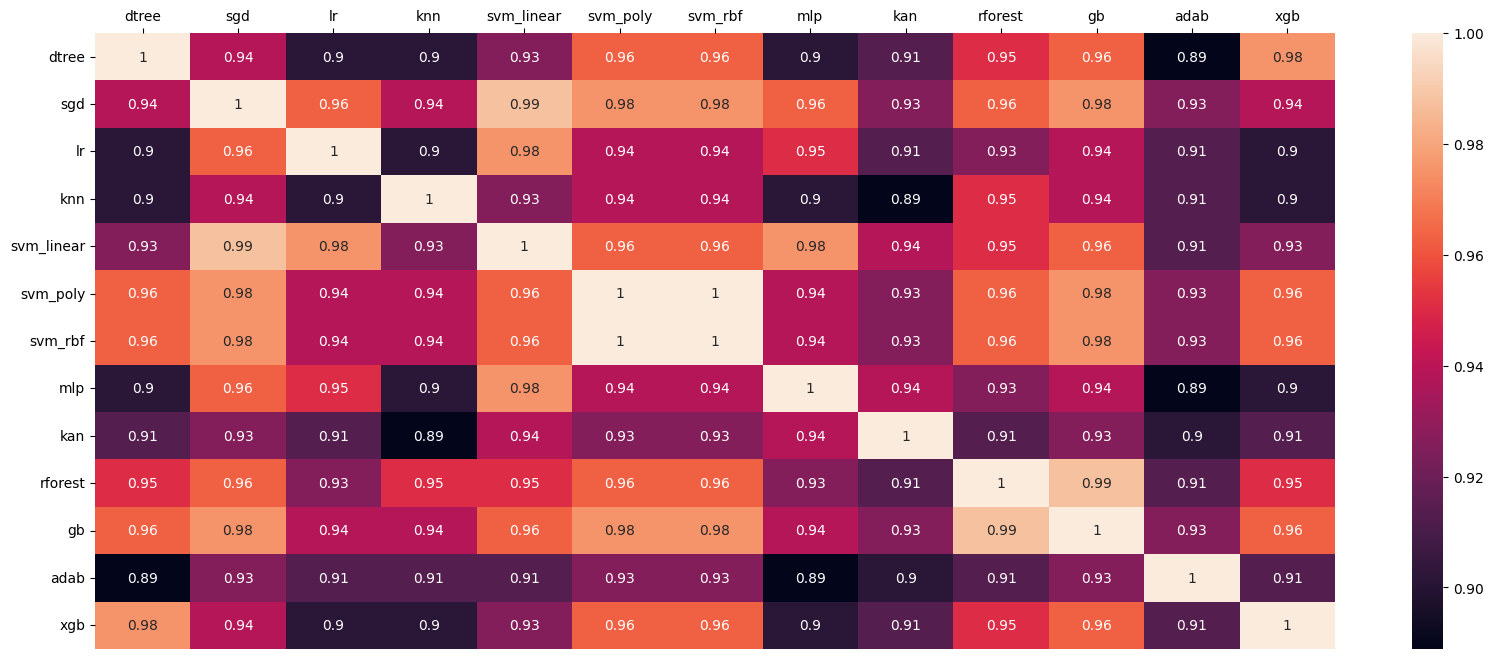

In [278]:
plt.figure(figsize=(20,8))
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [279]:
corrls_values = pd.Series(regchain_corrls.values.reshape((169,)))
corrls_values.describe()

count    169.000000
mean       0.943020
std        0.030658
min        0.888889
25%        0.925926
50%        0.938272
75%        0.962963
max        1.000000
dtype: float64

In [280]:
min_score = corrls_values.quantile(0.75)

regchain_corrls_min = regchain_corrls.map(lambda x: np.NAN if (x<min_score) or (x==1) else x)

unsqueeze(group_search(regchain_corrls_min, min_score))

for i in range(len(groups_list)):
    groups_list[i].sort()

i = 0
while i < len(groups_list):
    if(groups_list.count(groups_list[i])>1):
        groups_list.pop(i)
    else:
        i+=1

for g in groups_list:
    if(len(g)>1):
        print(g)

['knn', 'lr', 'sgd']
['lr', 'sgd', 'svm_linear', 'xgb']
['knn', 'lr', 'svm_poly']
['lr', 'mlp', 'svm_linear', 'svm_poly']
['lr', 'svm_linear', 'xgb']
['knn', 'svm_poly']
['knn', 'svm_rbf']
['mlp', 'svm_linear', 'svm_poly']
['adab', 'svm_linear', 'svm_poly']
['svm_linear', 'xgb']
['mlp', 'svm_poly']
['adab', 'gb', 'svm_poly']
['adab', 'gb']
['dtree', 'gb', 'svm_poly', 'xgb']
['dtree', 'gb', 'svm_rbf', 'xgb']
['lr', 'sgd', 'svm_linear']
['mlp', 'sgd', 'svm_linear']
['gb', 'sgd', 'svm_linear', 'svm_poly']
['gb', 'sgd', 'svm_linear', 'svm_rbf']
['gb', 'rforest', 'sgd', 'svm_poly']
['gb', 'rforest', 'sgd', 'svm_rbf']
['lr', 'svm_linear']
['mlp', 'svm_linear']
['gb', 'svm_linear', 'svm_poly']
['gb', 'svm_linear', 'svm_rbf']
['gb', 'rforest', 'svm_poly']
['gb', 'svm_poly', 'xgb']
['gb', 'rforest', 'svm_rbf']
['gb', 'svm_rbf', 'xgb']
['gb', 'rforest']
['gb', 'xgb']


ver um jeito de limpar isso ^^^

In [281]:
regchain_groups = groups_list.copy()

### Multi-Output Regressor 
(ST)

In [112]:
mor = MultiOutputRegressor(RandomForestRegressor(), n_jobs=-1).fit(Xa_train, ya_train)

In [181]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

MSE: 0.0619
RMSE: 0.2256
MAE: 0.1714


In [233]:
ya_pred = mor.predict(Xa_test)

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.033744,0.062394,0.009225,0.057829,0.034379,0.053125,0.045077,0.089472,0.111956,0.053151,0.069094,0.007165,0.055314
multi-output,0.028104,0.105477,0.011389,0.077299,0.052487,0.088438,0.059653,0.116271,0.156628,0.069817,0.120319,0.008892,0.097786
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Análise de correlações:

In [ ]:
pred_hits3 = {}

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict(Xa_test.drop(columns=['target']))
    else:
        y_pred = models[i].predict(Xa_test_norm)
        
    pred_hits3[model_names[i]] = y_pred == Xa_test['target']

In [ ]:
regchain_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)
size_preds = len(ya_test)

for m in model_names:
    for n in model_names:
        regchain_corrls.at[m,n] = ((pred_hits2[m] == pred_hits2[n]).sum())/size_preds

regchain_corrls

In [ ]:
plt.figure(figsize=(20,8))
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [ ]:
corrls_values2 = pd.Series(regchain_corrls.values.reshape((169,)))
corrls_values2.describe()

In [ ]:
min_score = corrls_values2.quantile(0.75)

regchain_corrls_min = regchain_corrls.map(lambda x: np.NAN if (x<min_score) or (x==1) else x)

groups_list = []

unsqueeze(group_search(regchain_corrls_min, min_score))

for i in range(len(groups_list)):
    groups_list[i].sort()

i = 0
while i < len(groups_list):
    if(groups_list.count(groups_list[i])>1):
        groups_list.pop(i)
    else:
        i+=1

for g in groups_list:
    if(len(g)>1):
        print(g)

## Individuais

In [117]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.7104

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Score: 0.0537

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.2467

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.2792

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.3408

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'min_samp

In [131]:
mse_avg = 0
rmse_avg = 0
mae_avg = 0

for m in model_names:
    mse_avg += mse(ya_test[m], ind_assessors[m].predict(Xa_test))
    rmse_avg += rmse(ya_test[m], ind_assessors[m].predict(Xa_test))
    mae_avg += mae(ya_test[m], ind_assessors[m].predict(Xa_test))

mse_avg /= 13
rmse_avg /= 13
mae_avg /= 13

In [132]:
print(mse_avg, rmse_avg, mae_avg)

0.059638026698275 0.22264969993716993 0.1668364442978061


In [234]:
for m in model_names:
    mse_df.at['individual',m] = mse(ya_test[m], ind_assessors[m].predict(Xa_test))
    rmse_df.at['individual',m] = rmse(ya_test[m], ind_assessors[m].predict(Xa_test))
    mae_df.at['individual',m] = mae(ya_test[m], ind_assessors[m].predict(Xa_test))

mse_df

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.033744,0.062394,0.009225,0.057829,0.034379,0.053125,0.045077,0.089472,0.111956,0.053151,0.069094,0.007165,0.055314
multi-output,0.028104,0.105477,0.011389,0.077299,0.052487,0.088438,0.059653,0.116271,0.156628,0.069817,0.120319,0.008892,0.097786
individual,0.015080,0.107443,0.005426,0.044940,0.027895,0.057335,0.036220,0.102692,0.147645,0.037342,0.120809,0.002676,0.069791


In [236]:
mse_df = mse_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='MSE')
mse_df = mse_df.rename(columns={'index': 'assessor_type'})

rmse_df = rmse_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='RMSE')
rmse_df = rmse_df.rename(columns={'index': 'assessor_type'})

mae_df = mae_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='MAE')
mae_df = mae_df.rename(columns={'index': 'assessor_type'})
mse_df

,assessor_type,Modelo,MSE
0,regchain,dtree,0.033744
1,multi-output,dtree,0.028104
2,individual,dtree,0.015080
3,regchain,sgd,0.062394
4,multi-output,sgd,0.105477
5,individual,sgd,0.107443
6,regchain,lr,0.009225
7,multi-output,lr,0.011389
8,individual,lr,0.005426
9,regchain,knn,0.057829


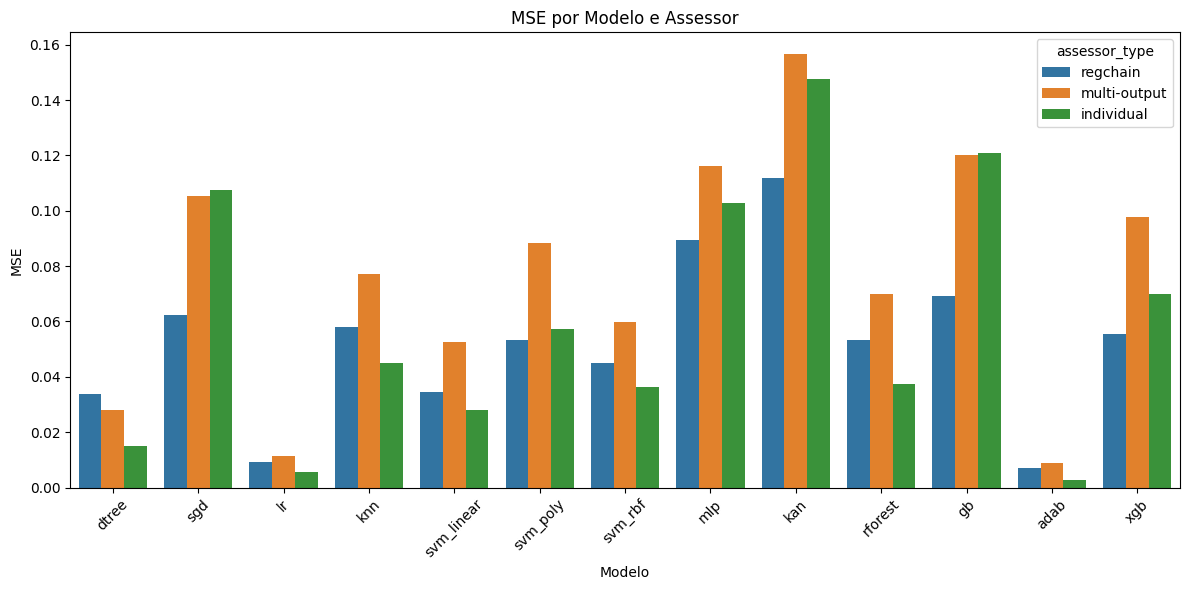

In [237]:
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='Modelo', y='MSE', hue='assessor_type')
plt.title('MSE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

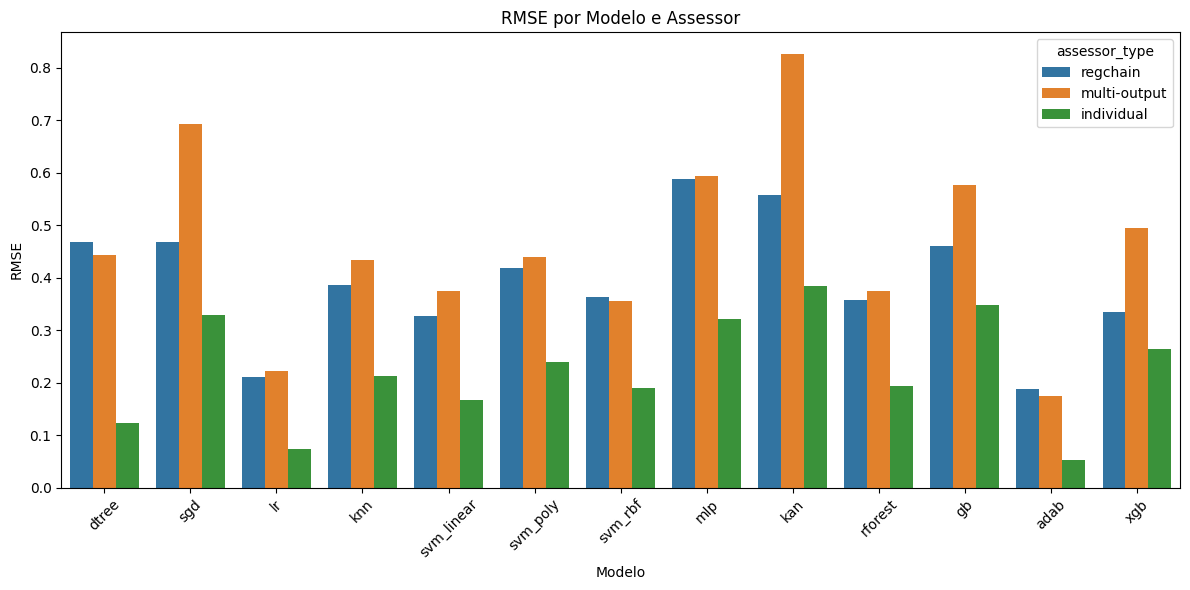

In [238]:
plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df, x='Modelo', y='RMSE', hue='assessor_type')
plt.title('RMSE por Modelo e Assessor')
plt.xticks(rotation=45)
#plt.legend(title='Assessor', labels=['RegChain', 'Multi-Output', 'Individual'])
plt.tight_layout()
plt.show()

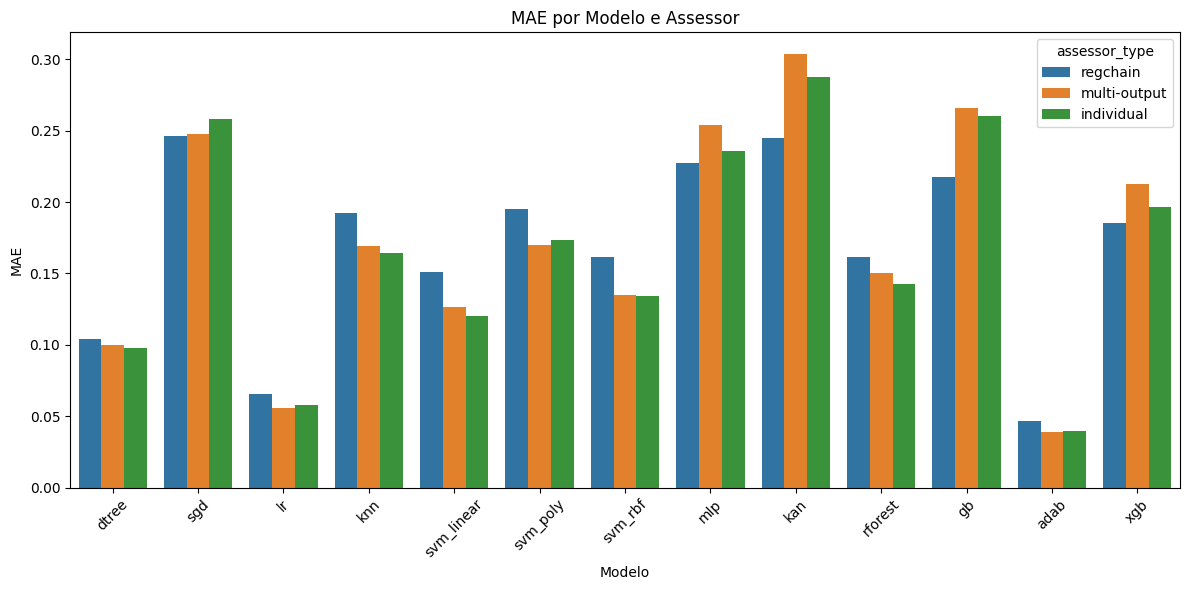

In [239]:
plt.figure(figsize=(12, 6))
sns.barplot(data=mae_df, x='Modelo', y='MAE', hue='assessor_type')
plt.title('MAE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Grupais